<h1><center><b>Improving Deep Learning for Indoor-Outdoor Detection (IOD)</center></h1></b>

<h2><b>  Author:</h2></b>

        Bilal Dastagir     

## Mount Google Colab

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dataset_Path = '/content/gdrive/MyDrive/Datasets/'
    model_Path = '/content/gdrive/MyDrive/models/'
except:
    dataset_Path = '/home/bilz/IODNET/Datasets/'
    model_Path = '/home/bilz/IODNET/models/'

dataset_Path_Full = dataset_Path + 'trainingTestingData.csv'
DATA_PATH = dataset_Path_Full
print(DATA_PATH)

trainingTestingData.csv


In [2]:
windows_Size = 50

<h2><b>  Importing all the necessary libraries </h2></b>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from matplotlib.pyplot import figure
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
#Printing the version of TensorFlow in use
print(tf.__version__)

2023-07-19 10:59:07.003231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 10:59:07.108085: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-19 10:59:07.108100: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-19 10:59:07.509954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

2.11.0


## Improving Deep Learning for Indoor-Outdoor Detection (IOD) in Location-Based Service (LBS)

<h2><b> Pre-processing of the Dataset </b></h2>

In [4]:
# load the original CSV file into a DataFrame
df = pd.read_csv(DATA_PATH)
print(df.head())

    RSRP  RSRQ  Light        Mag       Acc    Sound  Proximity  Daytime  \
0 -105.0  -9.0    2.0  37.842307  0.009740  -7.6329        5.0        0   
1 -103.0 -12.0    2.0  55.649774  0.010544  44.3180        5.0        0   
2  -92.0 -15.0   76.0  69.694050  0.009716  16.1690        5.0        0   
3 -112.0 -12.0    2.0  52.046729  0.231601  47.5940        0.0        1   
4 -100.0 -13.0    2.0  46.116479  0.012331  20.1266        0.0        0   

   New_Recording   IO  
0              0  1.0  
1              0  1.0  
2              0  1.0  
3              0  1.0  
4              0  1.0  


In [5]:
columns = ['RSRP','RSRQ','Light','Mag','Acc','Sound','Proximity','Daytime','New_Recording','IO']
data = pd.DataFrame(data = df, columns = columns)
print('Shape of the data:', data.shape)
# Converting the string formatted data into float
data['RSRP'] = data['RSRP'].astype('float')
data['RSRQ'] = data['RSRQ'].astype('float')
data['Light'] = data['Light'].astype('float')
data['Mag'] = data['Mag'].astype('float')
data['Acc'] = data['Acc'].astype('float')
data['Sound'] = data['Sound'].astype('float')
data['Proximity'] = data['Proximity'].astype('float')
data['Daytime'] = data['Daytime'].astype('float')
data['New_Recording'] = data['New_Recording'].astype('float')
data['IO'] = data['IO'].astype('float')
states = data['IO'].value_counts().index

Shape of the data: (1325958, 10)


In [6]:
data.reset_index(drop=True, inplace=True)
data.index = data.index + 1
data.index.name = 'index'


In [7]:
# load the original CSV file into a DataFrame
print(data.head())

        RSRP  RSRQ  Light        Mag       Acc    Sound  Proximity  Daytime  \
index                                                                         
1     -105.0  -9.0    2.0  37.842307  0.009740  -7.6329        5.0      0.0   
2     -103.0 -12.0    2.0  55.649774  0.010544  44.3180        5.0      0.0   
3      -92.0 -15.0   76.0  69.694050  0.009716  16.1690        5.0      0.0   
4     -112.0 -12.0    2.0  52.046729  0.231601  47.5940        0.0      1.0   
5     -100.0 -13.0    2.0  46.116479  0.012331  20.1266        0.0      0.0   

       New_Recording   IO  
index                      
1                0.0  1.0  
2                0.0  1.0  
3                0.0  1.0  
4                0.0  1.0  
5                0.0  1.0  


###  Balancing the Dataset

As observed "Indoor" has the most values, whereas the label "Outdoor" has the least

In [8]:
df['IO'].value_counts()

1.0    822398
0.0    503560
Name: IO, dtype: int64

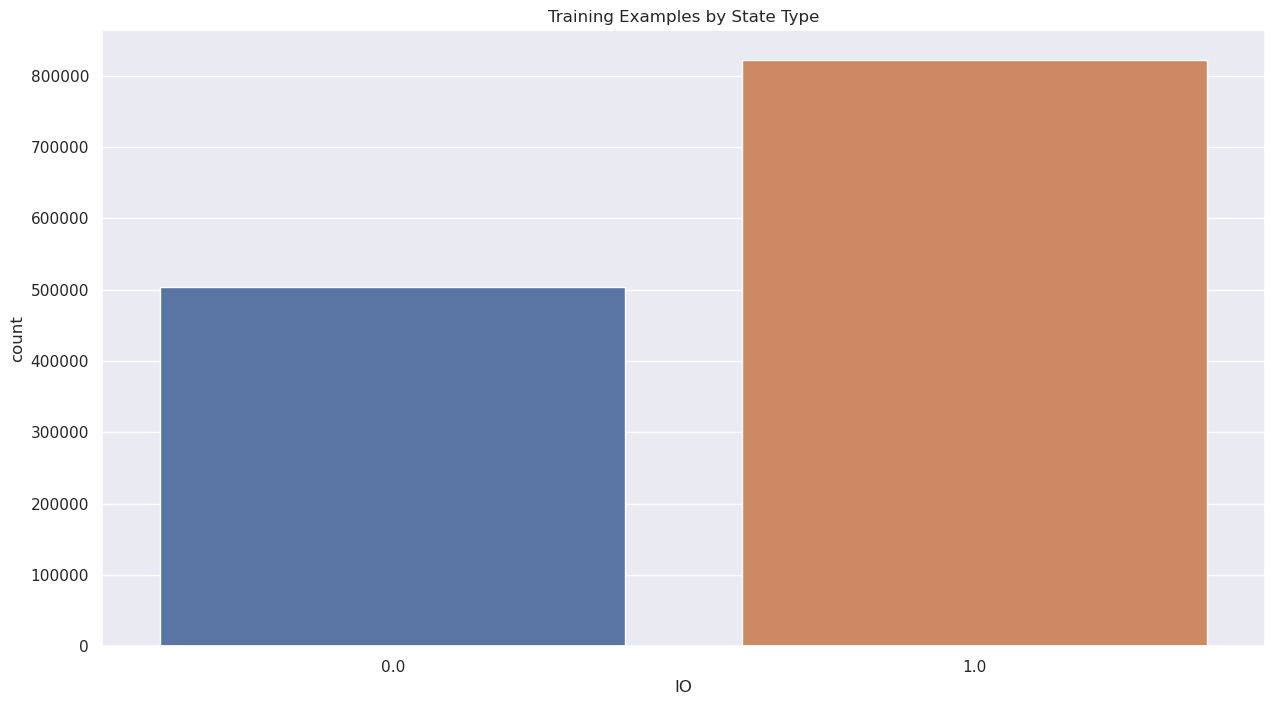

In [9]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'IO', data = df)
plt.title('Training Examples by State Type')
plt.show()

Since "Outdoor" has the least quantity of data, we have taken it as a reference for balancing

In [10]:
Outdoor = df[df['IO'] == 0].head(500000).copy()
Indoor = df[df['IO'] == 1].head(500000).copy()

In [11]:
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Outdoor, Indoor])
balanced_data.shape

(1000000, 10)

In [12]:
# Displaying the balanced data
print('State Count:',balanced_data['IO'].value_counts())

State Count: 0.0    500000
1.0    500000
Name: IO, dtype: int64


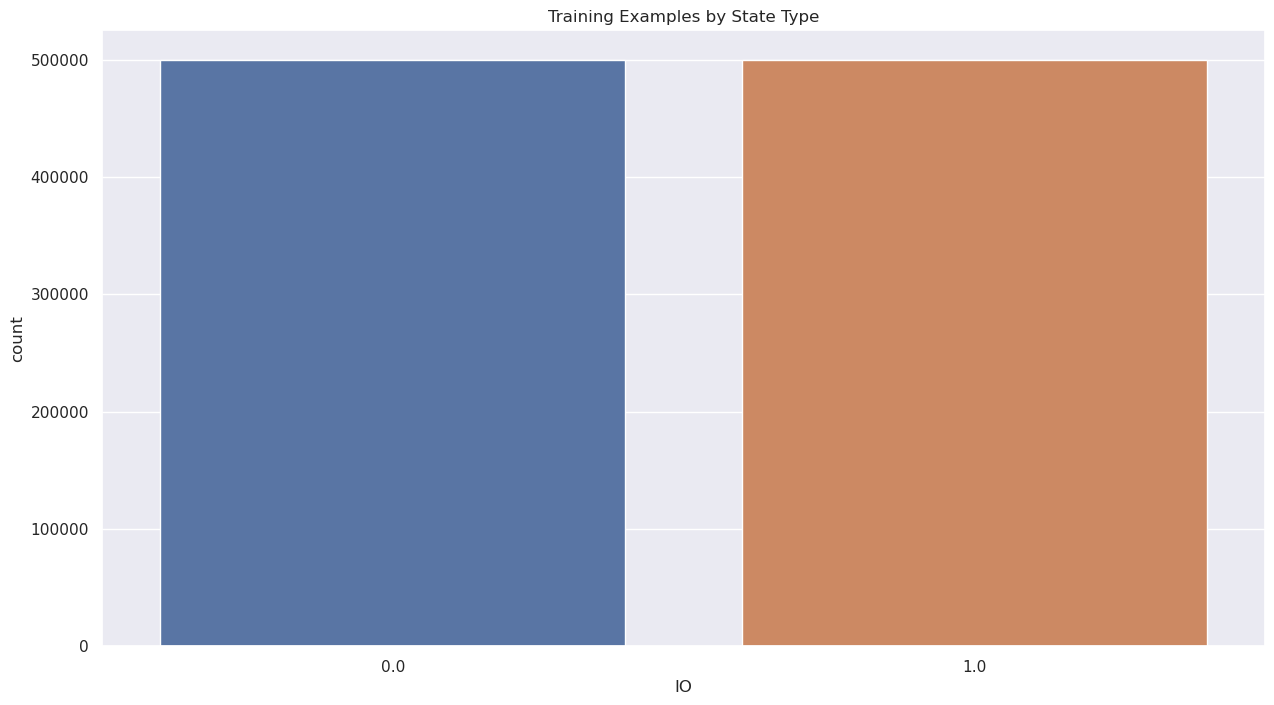

In [13]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'IO', data = balanced_data)
plt.title('Training Examples by State Type')
plt.show()

In [14]:
# Encoding the Data with suitable labels
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['IO'])
balanced_data.head()

,RSRP,RSRQ,Light,Mag,Acc,Sound,Proximity,Daytime,New_Recording,IO,label
9,-97.0,-17.0,0.66,44.348269,0.163469,50.13800,0.0,0,0,0.0,0
10,-61.0,-7.0,2.00,37.940366,2.178142,53.58200,0.0,0,0,0.0,0
13,-81.0,-12.0,151.00,52.495285,0.199459,32.57729,5.0,0,0,0.0,0
21,-81.0,-10.0,2.00,43.770242,2.769156,43.19700,0.0,0,0,0.0,0
22,-91.0,-7.0,2.00,40.528055,3.292488,43.45796,0.0,0,0,0.0,0


### Standardizing the Dataset

In [15]:
X = balanced_data[['RSRP','RSRQ','Light','Mag','Acc','Sound','Proximity','Daytime']]
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['RSRP','RSRQ','Light','Mag','Acc','Sound','Proximity','Daytime'])
scaled_X['label'] = y.values

scaled_X

,RSRP,RSRQ,Light,Mag,Acc,Sound,Proximity,Daytime,label
0,-0.010360,-1.449255,-0.203838,-0.058869,-0.513899,0.827644,-1.024678,-0.499948,0
1,2.715828,1.691476,-0.202620,-0.386117,0.731036,1.003386,-1.024678,-0.499948,0
2,1.201279,0.121111,-0.067163,0.357194,-0.491659,-0.068450,0.975916,-0.499948,0
3,1.201279,0.749257,-0.202620,-0.088389,1.096243,0.473456,-1.024678,-0.499948,0
4,0.444005,1.691476,-0.202620,-0.253965,1.419628,0.486773,-1.024678,-0.499948,0
...,...,...,...,...,...,...,...,...,...
999995,-0.161814,1.063330,-0.198984,-0.329447,-0.611986,-2.131847,-1.024678,-0.499948,1
999996,-0.237542,-0.192962,-0.168983,-0.210153,-0.605822,0.703237,-1.024678,2.000206,1
999997,-0.388997,-0.507035,-0.202620,-0.273531,0.771198,0.238114,-1.024678,-0.499948,1
999998,-1.221999,-0.192962,-0.138982,-0.103882,-0.611385,-0.763471,0.975916,-0.499948,1


### Frame Size and Other Settings

In [16]:
frame_size = windows_Size
hop_size = int(frame_size/2) 
n_features = 8

In [17]:


def get_frames(df, frame_size, hop_size, n_features=8):

    N_FEATURES = n_features

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):

        RSRP = df['RSRP'].values[i: i + frame_size]
        RSRQ = df['RSRQ'].values[i: i + frame_size]
        Light = df['Light'].values[i: i + frame_size]
        Mag = df['Mag'].values[i: i + frame_size]
        Acc = df['Acc'].values[i: i + frame_size]
        Sound = df['Sound'].values[i: i + frame_size]
        Proximity = df['Proximity'].values[i: i + frame_size]
        Daytime = df['Daytime'].values[i: i + frame_size]


        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([RSRP, RSRQ, Light, Mag, Acc, Sound, Proximity, Daytime])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [18]:
X.shape, y.shape
caled_X = scaled_X.replace([np.inf, -np.inf], np.nan)
scaled_X = scaled_X.dropna()
scaled_X = scaled_X.reset_index(drop=True)
X, y = get_frames(scaled_X, frame_size, hop_size)
X.shape, y.shape

((39998, 50, 8), (39998,))

### 6-fold cross-validation sets

In [19]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Creating the 6-fold cross-validation iterator
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)

X_train.shape, X_test.shape

((31998, 50, 8), (8000, 50, 8))

In [20]:
X_train[0].shape, X_test[0].shape

((50, 8), (50, 8))

In [21]:
#from keras.layers import Input
# Check the size of the original array
print(X_train.shape)

# Reshape the arrays (Needed for 2D)
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Check the shape of the reshaped arrays
print(X_train.shape)
print(X_test.shape)


input_shape = X_train[0].shape
print("input_shape = ",input_shape)

n_outputs = 2
epochSize = 16



(31998, 50, 8)
(31998, 50, 8)
(8000, 50, 8)
input_shape =  (50, 8)


<h2><b>Propose Model</h2></b>

In [22]:
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, LayerNormalization
from keras.layers import LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.models import Model

def CNN_LSTM(input_shape, n_outputs):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = LayerNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = LSTM(64)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(n_outputs, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [23]:
model = CNN_LSTM(input_shape, n_outputs)

2023-07-19 10:59:14.128930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 10:59:14.129182: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-19 10:59:14.129273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-07-19 10:59:14.129342: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-07-19 10:59:14.129403: W tensorflow/c

In [24]:
# Calculate the total number of parameters
total_params = model.count_params()

# Convert the total number of parameters to kilobytes (KB)
total_params_kb = total_params / 1024  # 1 KB = 1024 bytes

print(f"Total model parameters: {total_params_kb} K")

# Convert the total number of parameters to megabytes (MB)
total_memory_mb = total_params * 4 / (1024 * 1024)  # Assuming float32 precision (4 bytes per parameter)


print(f"Estimated memory required: {total_memory_mb:.2f} MB")


Total model parameters: 34.064453125 K
Estimated memory required: 0.13 MB


In [25]:
#X_train[0].shape

In [26]:
opt_adam = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [27]:
model.compile(optimizer=opt_adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [28]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Looping over the folds
for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
    print(f"Fold {fold+1}:")
    
    # Get the train and validation sets for this fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Define the filepath for the saved model specific to this fold
    filepath = model_Path + f"bd_KIODNet_CL_V1_W_6_F_{fold+1}.h5"

    # Define early stopping based on validation loss
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
        

    # Define a checkpoint to monitor the validation accuracy and save the best model
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    # Train the model with the checkpoint callback for this fold
    history = model.fit(X_train_fold, y_train_fold, epochs=epochSize, batch_size=16, validation_data=(X_val_fold, y_val_fold),
                        callbacks=[checkpoint], verbose=1)

Fold 1:
Epoch 1/16
2083/2084 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9977
Epoch 1: val_accuracy improved from -inf to 0.99985, saving model to /home/bilz/IODNET/models/bd_KIODNet_CL_V1_W_50_F_1.h5
2084/2084 [==============================] - 20s 9ms/step - loss: 0.0065 - accuracy: 0.9977 - val_loss: 0.0017 - val_accuracy: 0.9999
Epoch 2/16
2082/2084 [============================>.] - ETA: 0s - loss: 1.4174e-05 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.99985
2084/2084 [==============================] - 19s 9ms/step - loss: 1.4168e-05 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9999
Epoch 3/16
2078/2084 [============================>.] - ETA: 0s - loss: 3.2205e-06 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.99985
2084/2084 [==============================] - 18s 9ms/step - loss: 3.2159e-06 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9999
Epoch 4/16
2078/2084 [============================>.] -

In [29]:
import numpy as np
from keras.models import load_model



# Define the number of folds
n_splits = 6

# Create an empty list to store the fold models
fold_models = []

# Loop over the folds to load the saved models
for fold in range(n_splits):
    # Define the filepath of the saved model for this fold
    filepath = model_Path + f"bd_KIODNet_CL_V1_W_6_F_{fold+1}.h5"
    
    # Load the saved model
    fold_model = load_model(filepath)

    print("fold no ",fold)
    # Evaluate the model on the test set
    test_loss, test_acc = fold_model.evaluate(X_test, y_test, verbose=1)

    
    # Append the loaded model to the list
    fold_models.append(fold_model)

# Create a new model with the same architecture as the original model
averaged_model = fold_models[0]
averaged_weights = averaged_model.get_weights()

# Loop over the layers of the models and average the weights
for layer in range(len(averaged_weights)):
    for fold in range(1, n_splits):
        averaged_weights[layer] += fold_models[fold].get_weights()[layer]
    
    averaged_weights[layer] /= n_splits

# Set the averaged weights to the averaged model
averaged_model.set_weights(averaged_weights)

# Save the averaged model
averaged_model.save(model_Path +"bd_KIODNet_CL_V1_W_6.h5")


fold no  0
  1/250 [..............................] - ETA: 1:06 - loss: 2.0560e-05 - accuracy: 1.0000

250/250 [==============================] - 1s 3ms/step - loss: 2.2972e-05 - accuracy: 1.0000
fold no  1
250/250 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.9999
fold no  2
250/250 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000
fold no  3
250/250 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000
fold no  4
250/250 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000
fold no  5
250/250 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [30]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define the number of folds
n_splits = 6

# Create empty lists to store the fold models and evaluation results
fold_models = []
fold_test_acc = []
fold_test_f1 = []

# Loop over the folds to load the saved models
for fold in range(n_splits):
    # Define the filepath of the saved model for this fold
    filepath = model_Path + f"bd_KIODNet_CL_V1_W_6_F_{fold+1}.h5"
    
    # Load the saved model
    fold_model = load_model(filepath)

    print("Fold No:", fold+1)
    # Evaluate the model on the test set
    test_pred = fold_model.predict(X_test)
    test_pred_labels = np.argmax(test_pred, axis=1)
    
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        test_true_labels = np.argmax(y_test, axis=1)
    else:
        test_true_labels = y_test
    
    test_acc = accuracy_score(test_true_labels, test_pred_labels)
    test_f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
    print("Test Accuracy:", test_acc)
    print("Test F1-Score:", test_f1)
    
    # Append the loaded model and evaluation results to the lists
    fold_models.append(fold_model)
    fold_test_acc.append(test_acc)
    fold_test_f1.append(test_f1)

# Create a new model with the same architecture as the original model
averaged_model = fold_models[0]
averaged_weights = averaged_model.get_weights()

# Loop over the layers of the models and average the weights
for layer in range(len(averaged_weights)):
    for fold in range(1, n_splits):
        averaged_weights[layer] += fold_models[fold].get_weights()[layer]
    
    averaged_weights[layer] /= n_splits

# Set the averaged weights to the averaged model
averaged_model.set_weights(averaged_weights)

# Save the averaged model
averaged_model.save(model_Path +"bd_KIODNet_CL_V1_W_6.h5")


Fold No: 1
 93/250 [==========>...................] - ETA: 0s

250/250 [==============================] - 1s 3ms/step
Test Accuracy: 1.0
Test F1-Score: 1.0
Fold No: 2
250/250 [==============================] - 1s 3ms/step
Test Accuracy: 0.999875
Test F1-Score: 0.9998749999980469
Fold No: 3
250/250 [==============================] - 1s 3ms/step
Test Accuracy: 1.0
Test F1-Score: 1.0
Fold No: 4
250/250 [==============================] - 1s 3ms/step
Test Accuracy: 1.0
Test F1-Score: 1.0
Fold No: 5
250/250 [==============================] - 1s 3ms/step
Test Accuracy: 1.0
Test F1-Score: 1.0
Fold No: 6
250/250 [==============================] - 1s 3ms/step
Test Accuracy: 1.0
Test F1-Score: 1.0


In [31]:
from keras.models import load_model

# Load the saved model
saved_model = load_model(model_Path + 'bd_KIODNet_CL_V1_W_6.h5')

# Evaluate the model on the test set
test_loss, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)

print('Test accuracy:', test_acc)


Test accuracy: 1.0


In [32]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

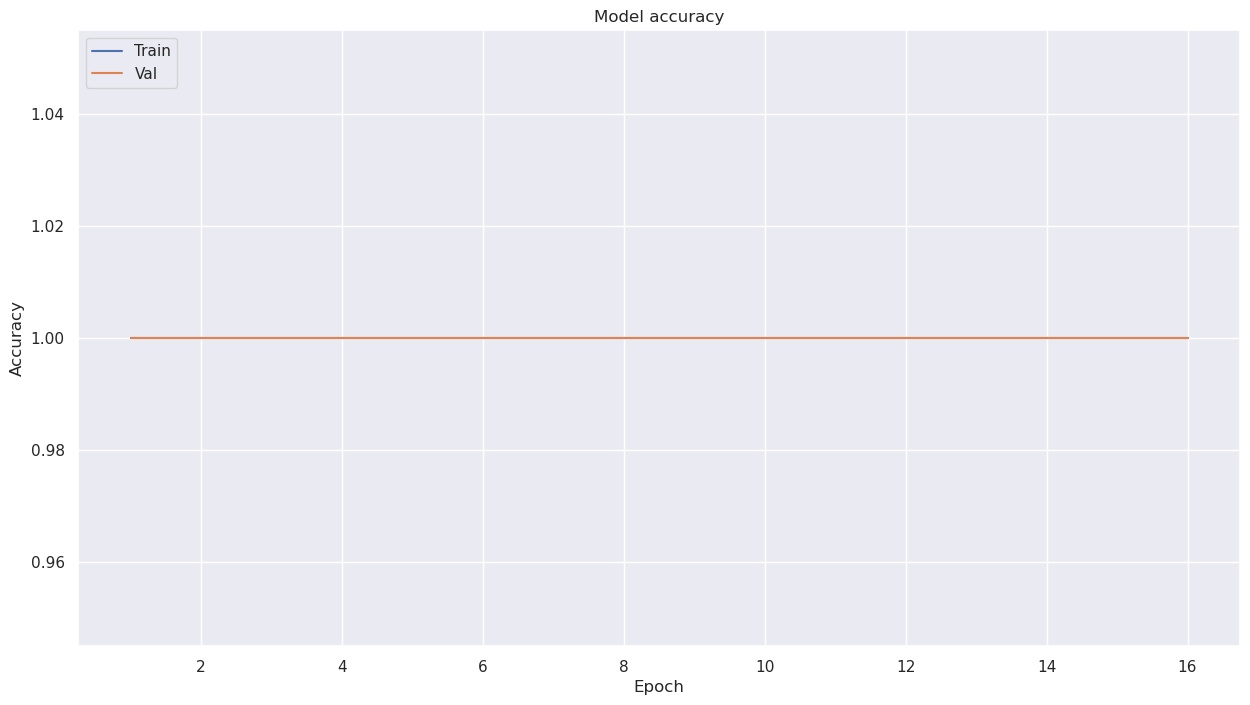

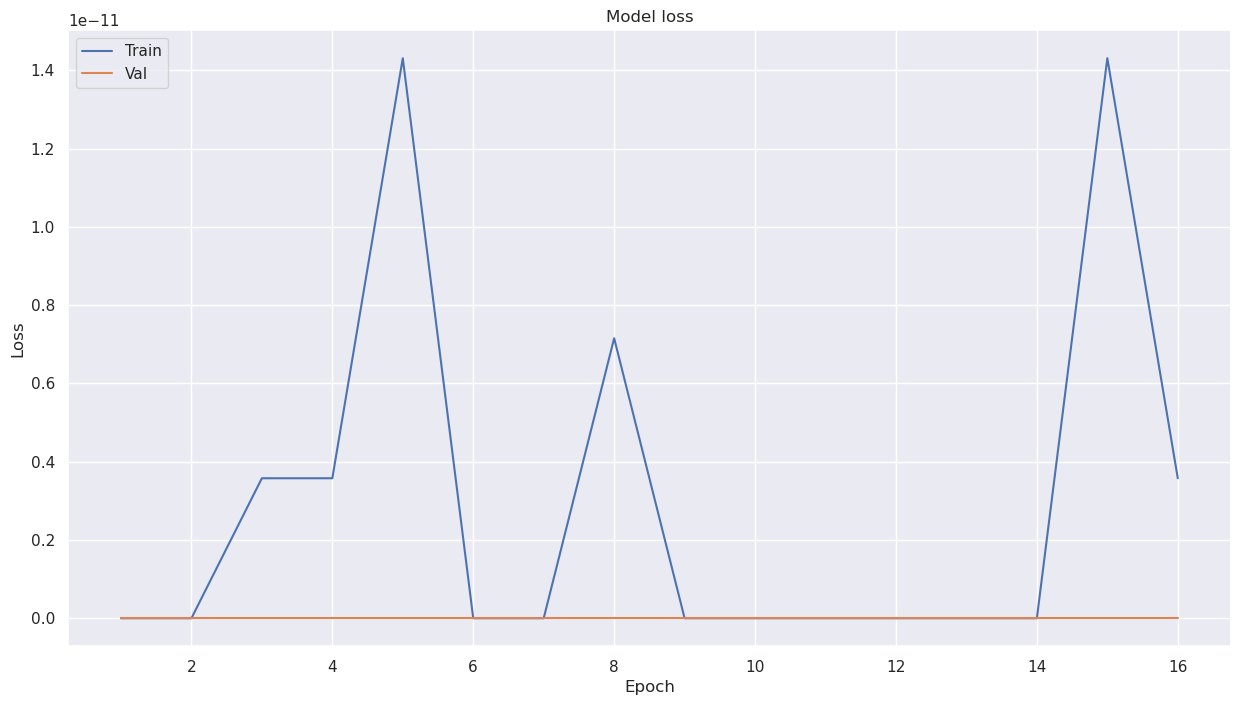

In [33]:
plot_learningCurve(history, epochSize)

<h2><b>Results</b></h2>

### Confusion Matrix

250/250 [==============================] - 1s 3ms/step
Prediction time: 1.3704063892364502 seconds


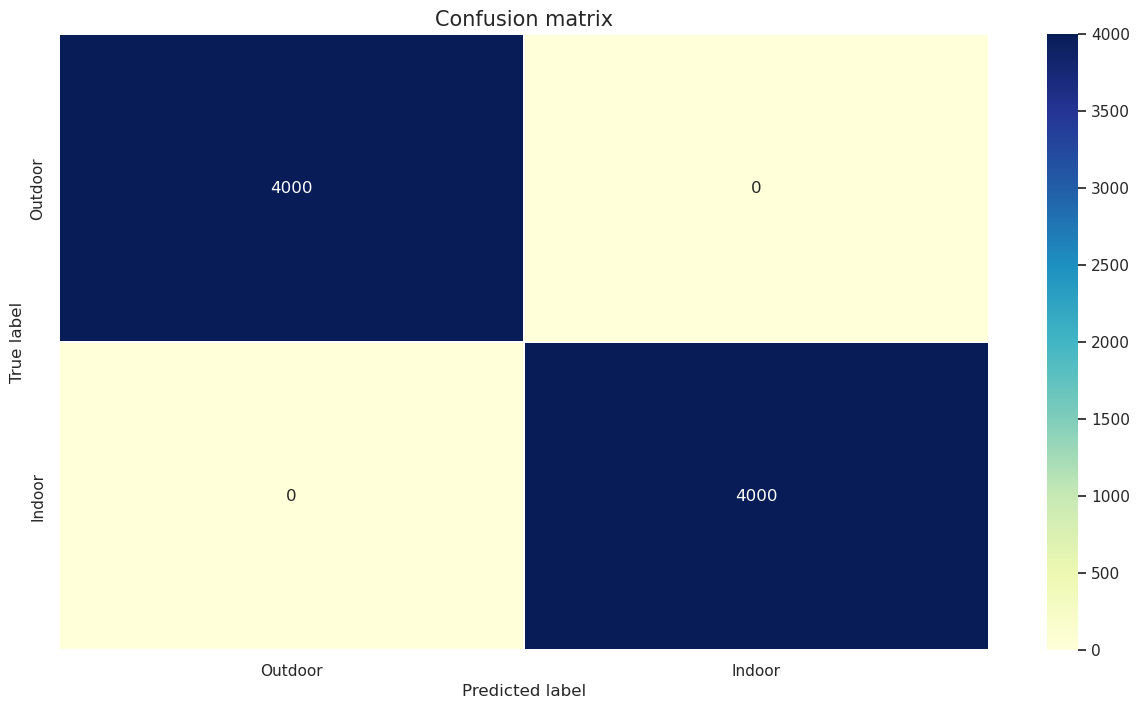

In [34]:
import time
class_labels = ['Outdoor', 'Indoor']
# Measure the time it takes to predict a single sample
start_time = time.time()
predict_x=saved_model.predict(X_test)
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time

print('Prediction time:', prediction_time, 'seconds')


y_pred=np.argmax(predict_x,axis=1)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



### Classification Report

In [35]:
results = precision_recall_fscore_support(y_test, y_pred, average='macro')

In [36]:
print("The Testing Accuracy of the model:            {} %".format(accuracy_score(y_test, y_pred)*100))
print(f'\nThe Precision of the given model is:   {results[0]*100} %')
print(f'\nThe Recall of the given model is:      {results[1]*100} %')
print(f'\nThe F1-score of the given model is:    {results[2]*100} %')

The Testing Accuracy of the model:            100.0 %

The Precision of the given model is:   100.0 %

The Recall of the given model is:      100.0 %

The F1-score of the given model is:    100.0 %


In [37]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dataset_Path = '/content/gdrive/MyDrive/Datasets/'
    model_Path = '/content/gdrive/MyDrive/models/'
except:
    dataset_Path = '/home/bilz/IODNET/Datasets/'
    model_Path = '/home/bilz/IODNET/models/'


DATA_PATH_VAL= dataset_Path + 'validatingData.csv'
print(DATA_PATH_VAL)

trainingTestingData.csv


# Load Testing (Validation Dataset)

    RSRP  RSRQ  Light        Mag       Acc     Sound  Proximity  Daytime  \
0  -98.0  -5.0    0.0  43.141047  0.861024  57.62903        0.0        0   
1 -109.0 -13.0  256.0  62.457436  0.119644  14.75510        5.0        1   
2  -97.0 -14.0    0.0  45.754401  0.027471  45.89380        0.0        0   
3 -112.0 -17.0    0.0  38.389198  0.009848  27.17500        5.0        0   
4 -100.0 -11.0   60.0  36.980915  0.009443  23.45800        5.0        0   

   New_Recording   IO  
0              0  0.0  
1              0  1.0  
2              0  1.0  
3              0  1.0  
4              0  1.0  
Shape of the data: (147329, 10)
        RSRP  RSRQ  Light        Mag       Acc     Sound  Proximity  Daytime  \
index                                                                          
1      -98.0  -5.0    0.0  43.141047  0.861024  57.62903        0.0      0.0   
2     -109.0 -13.0  256.0  62.457436  0.119644  14.75510        5.0      1.0   
3      -97.0 -14.0    0.0  45.754401  0.027471 

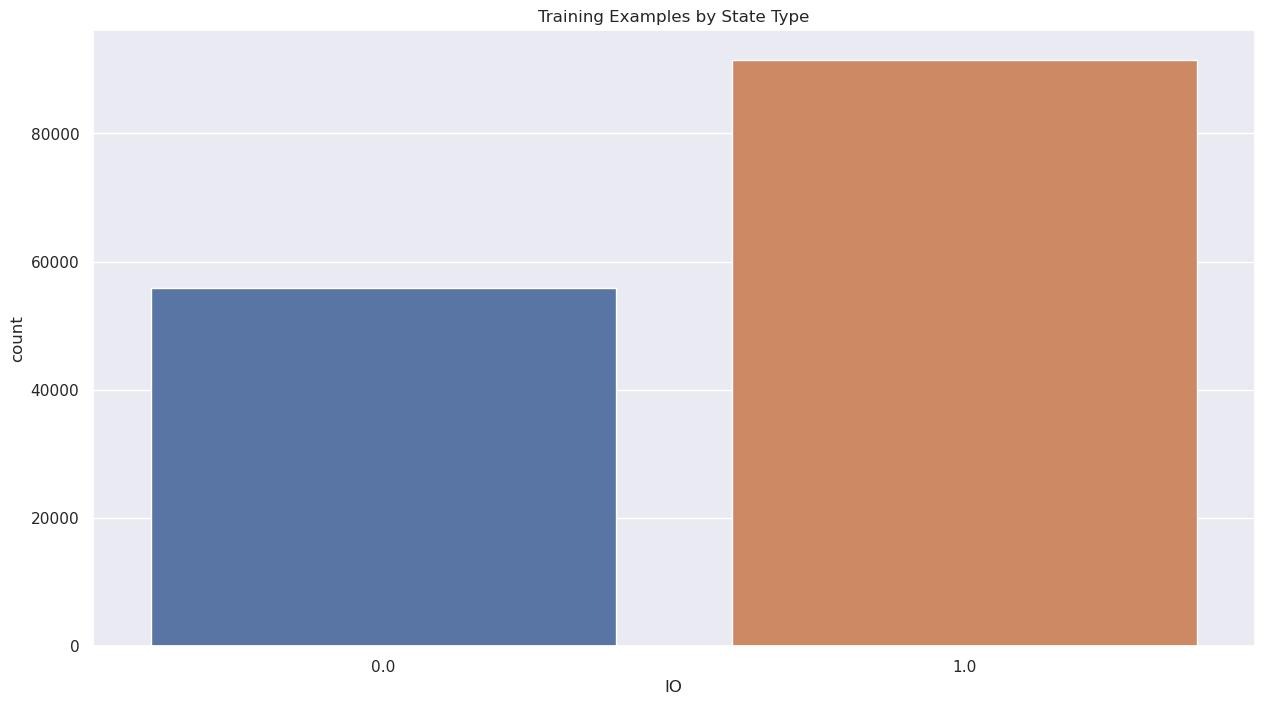

State Count: 0.0    50000
1.0    50000
Name: IO, dtype: int64


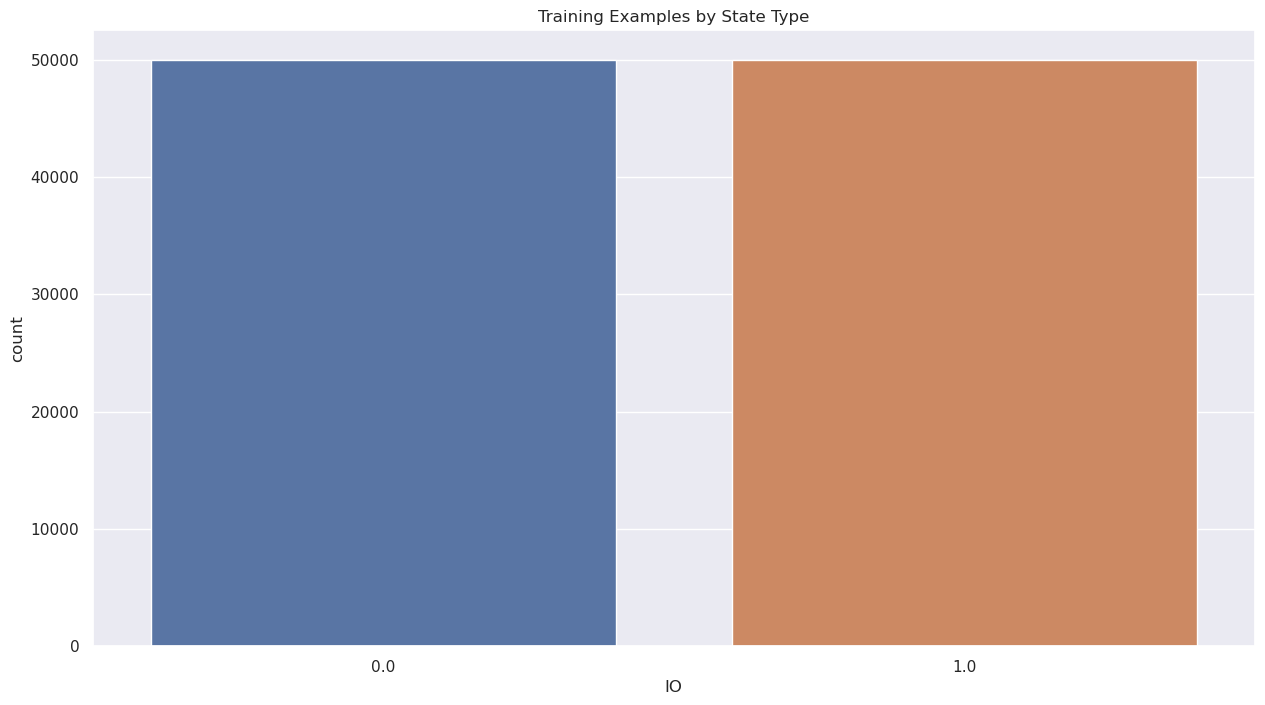

((3998, 50, 8), (3998,))

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats
from sklearn.metrics import precision_recall_fscore_support


# load the otesting Data CSV file into a DataFrame
df = pd.read_csv(DATA_PATH_VAL)
print(df.head())

frame_size = windows_Size
hop_size = int(frame_size/2) 
n_features = 8


def get_frames(df, frame_size, hop_size, n_features=8):

    N_FEATURES = n_features

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):

        RSRP = df['RSRP'].values[i: i + frame_size]
        RSRQ = df['RSRQ'].values[i: i + frame_size]
        Light = df['Light'].values[i: i + frame_size]
        Mag = df['Mag'].values[i: i + frame_size]
        Acc = df['Acc'].values[i: i + frame_size]
        Sound = df['Sound'].values[i: i + frame_size]
        Proximity = df['Proximity'].values[i: i + frame_size]
        Daytime = df['Daytime'].values[i: i + frame_size]


        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([RSRP, RSRQ, Light, Mag, Acc, Sound, Proximity, Daytime])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

columns = ['RSRP','RSRQ','Light','Mag','Acc','Sound','Proximity','Daytime','New_Recording','IO']
data = pd.DataFrame(data = df, columns = columns)
print('Shape of the data:', data.shape)
# Converting the string formatted data into float
data['RSRP'] = data['RSRP'].astype('float')
data['RSRQ'] = data['RSRQ'].astype('float')
data['Light'] = data['Light'].astype('float')
data['Mag'] = data['Mag'].astype('float')
data['Acc'] = data['Acc'].astype('float')
data['Sound'] = data['Sound'].astype('float')
data['Proximity'] = data['Proximity'].astype('float')
data['Daytime'] = data['Daytime'].astype('float')
data['New_Recording'] = data['New_Recording'].astype('float')
data['IO'] = data['IO'].astype('float')
states = data['IO'].value_counts().index

data.reset_index(drop=True, inplace=True)
data.index = data.index + 1
data.index.name = 'index'

# load the original CSV file into a DataFrame
print(data.head())

df['IO'].value_counts()

# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'IO', data = df)
plt.title('Training Examples by State Type')
plt.show()

Outdoor = df[df['IO'] == 0].sample(n=np.random.randint(1000, 4001)).copy()
Indoor = df[df['IO'] == 1].sample(n=np.random.randint(1000, 4001)).copy()

balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Outdoor, Indoor])
balanced_data.shape

# Displaying the balanced data
print('State Count:',balanced_data['IO'].value_counts())

# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'IO', data = balanced_data)
plt.title('Training Examples by State Type')
plt.show()

# Encoding the Data with suitable labels
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['IO'])
balanced_data.head()

X = balanced_data[['RSRP','RSRQ','Light','Mag','Acc','Sound','Proximity','Daytime']]
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['RSRP','RSRQ','Light','Mag','Acc','Sound','Proximity','Daytime'])
scaled_X['label'] = y.values

scaled_X

X.shape, y.shape
caled_X = scaled_X.replace([np.inf, -np.inf], np.nan)
scaled_X = scaled_X.dropna()
scaled_X = scaled_X.reset_index(drop=True)
X, y = get_frames(scaled_X, frame_size, hop_size)
X.shape, y.shape



## Load Trained Model

In [39]:
from keras.models import load_model
import time
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Load the saved model
trained_model = load_model(model_Path + 'bd_KIODNet_CL_V1_W_6.h5')

# Evaluate the model on the test set
test_loss, test_acc = trained_model.evaluate(X, y, verbose=1)

print('Test accuracy:', test_acc)

# Measure the time it takes to predict a single sample
start_time = time.time()
predict_x = trained_model.predict(X)
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time

print('Prediction time:', prediction_time, 'seconds')

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predict_x, axis=1)

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(y, predicted_labels, average='macro')

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)
print('Support:', support)


125/125 [==============================] - 1s 3ms/step - loss: 2.3854e-10 - accuracy: 1.0000
Test accuracy: 1.0
125/125 [==============================] - 1s 3ms/step
Prediction time: 0.7052974700927734 seconds
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Support: None


125/125 [==============================] - 1s 4ms/step - loss: 2.3854e-10 - accuracy: 1.0000
Test accuracy: 1.0
125/125 [==============================] - 1s 3ms/step
Prediction time: 0.6612544059753418 seconds
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Support: None


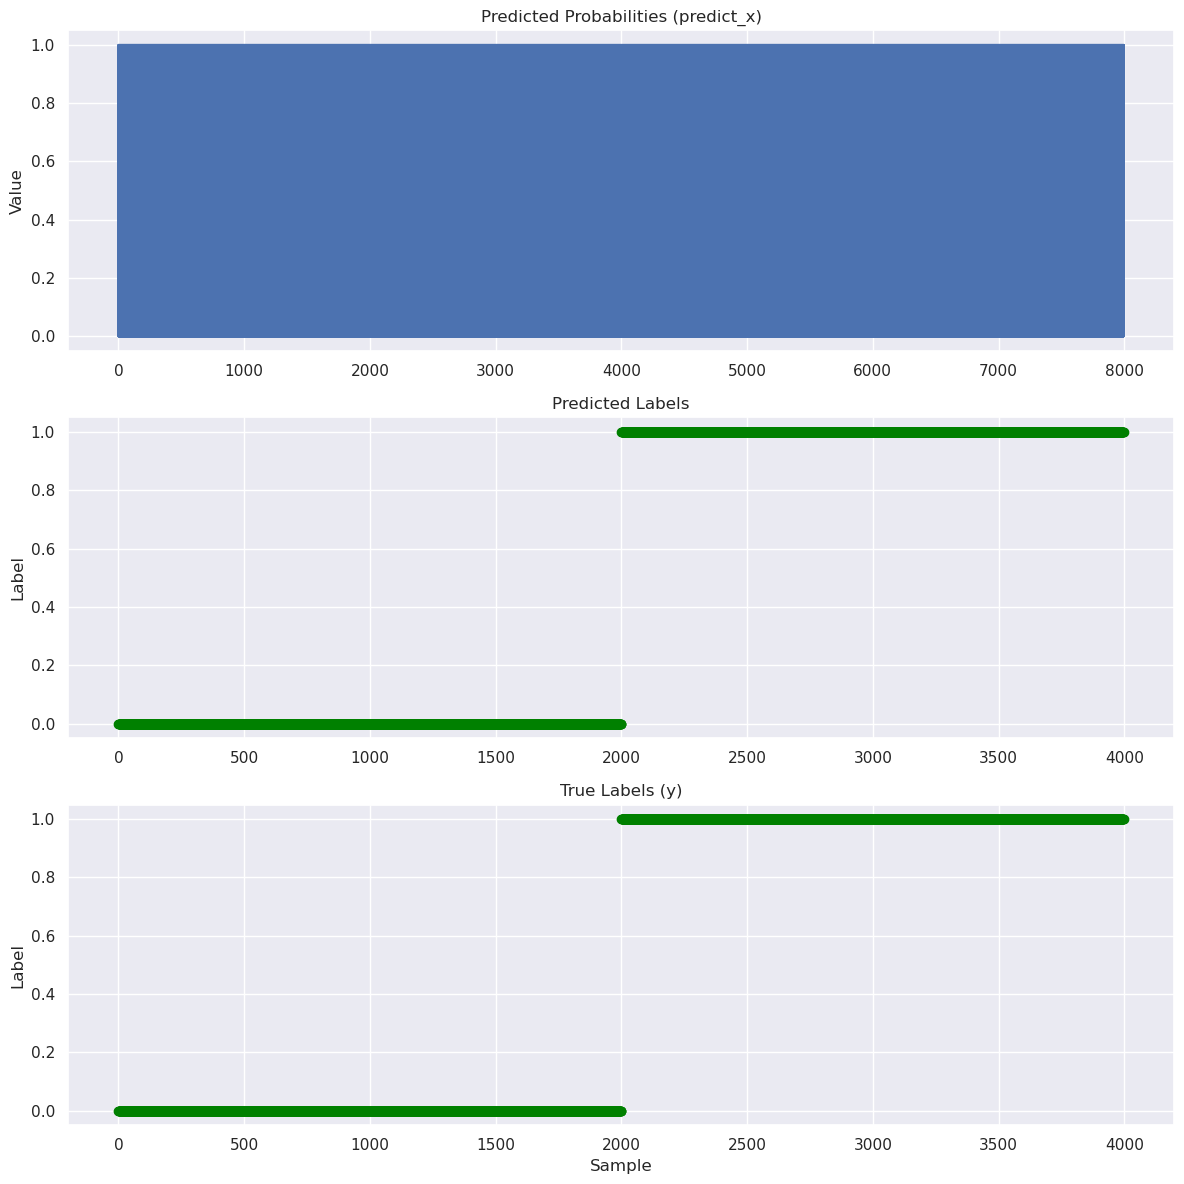

In [40]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from keras.models import load_model

# Load the saved model
trained_model = load_model(model_Path + 'bd_KIODNet_CL_V1_W_6.h5')

# Evaluate the model on the test set
test_loss, test_acc = trained_model.evaluate(X, y, verbose=1)
print('Test accuracy:', test_acc)

# Measure the time it takes to predict a single sample
start_time = time.time()
predict_x = trained_model.predict(X)
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time
print('Prediction time:', prediction_time, 'seconds')

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predict_x, axis=1)

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(y, predicted_labels, average='macro')
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)
print('Support:', support)

# Create subplots for the graphs
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot predict_x
axes[0].plot(predict_x.flatten(), label='predict_x')
axes[0].set_ylabel('Value')
axes[0].set_title('Predicted Probabilities (predict_x)')

# Plot predicted_labels with correct predictions in green and wrong predictions in red
for i in range(len(predicted_labels)):
    color = 'green' if predicted_labels[i] == y[i] else 'red'
    axes[1].scatter(i, predicted_labels[i], c=color, label='predicted_labels')
axes[1].set_ylabel('Label')
axes[1].set_title('Predicted Labels')

# Plot y with correct predictions in green and wrong predictions in red
for i in range(len(y)):
    color = 'green' if predicted_labels[i] == y[i] else 'red'
    axes[2].scatter(i, y[i], c=color, label='y')
axes[2].set_xlabel('Sample')
axes[2].set_ylabel('Label')
axes[2].set_title('True Labels (y)')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


125/125 [==============================] - 1s 3ms/step - loss: 2.3854e-10 - accuracy: 1.0000
Test accuracy: 1.0
125/125 [==============================] - 1s 3ms/step
Prediction time: 0.6556358337402344 seconds
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Support: None


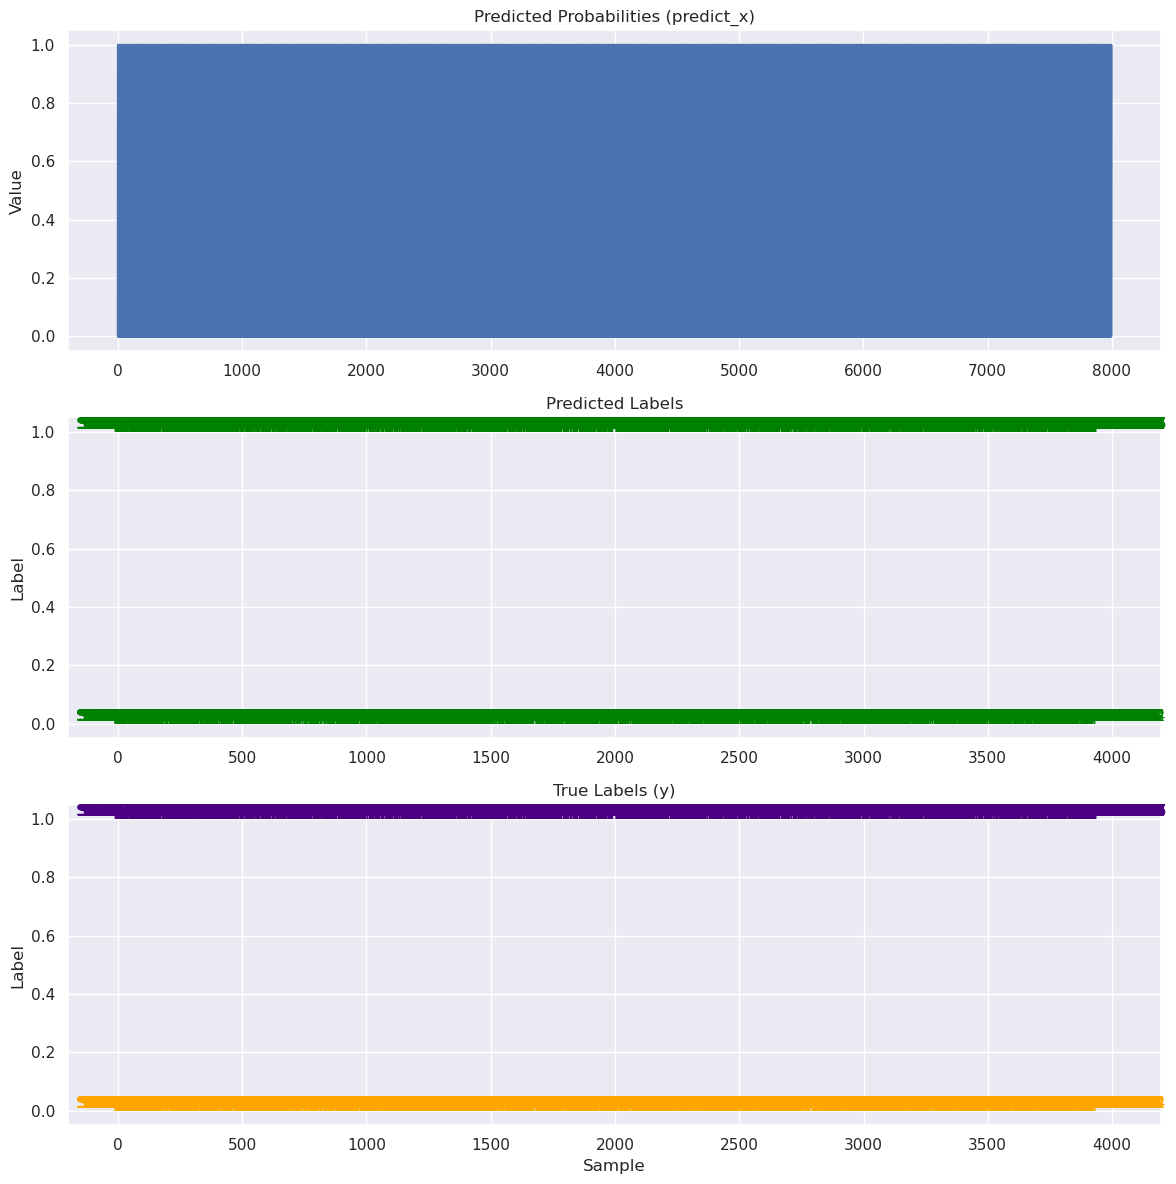

In [41]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from keras.models import load_model

# Load the saved model
trained_model = load_model(model_Path + 'bd_KIODNet_CL_V1_W_6.h5')

# Randomize the samples
random_indices = np.random.permutation(len(X))
X_randomized = X[random_indices]
y_randomized = y[random_indices]

# Evaluate the model on the test set
test_loss, test_acc = trained_model.evaluate(X_randomized, y_randomized, verbose=1)
print('Test accuracy:', test_acc)

# Measure the time it takes to predict a single sample
start_time = time.time()
predict_x = trained_model.predict(X_randomized)
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time
print('Prediction time:', prediction_time, 'seconds')

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predict_x, axis=1)

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(y_randomized, predicted_labels, average='macro')
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)
print('Support:', support)

# Create subplots for the graphs
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot predict_x
axes[0].plot(predict_x.flatten(), label='predict_x')
axes[0].set_ylabel('Value')
axes[0].set_title('Predicted Probabilities (predict_x)')

# Plot predicted_labels with correct predictions in green and wrong predictions in red
for i in range(len(predicted_labels)):
    color = 'green' if predicted_labels[i] == y_randomized[i] else 'red'
    axes[1].plot([i, i], [predicted_labels[i], y_randomized[i]], c=color)
    axes[1].text(i, predicted_labels[i], f'Sample {i}', ha='center', va='bottom', color=color)
axes[1].set_ylabel('Label')
axes[1].set_title('Predicted Labels')

# Plot y with correct predictions in green and wrong predictions in red
for i in range(len(y_randomized)):
    color = 'indigo' if y_randomized[i] == 1 else 'orange'
    #color = 'green' if predicted_labels[i] == y_randomized[i] else 'red'
    axes[2].plot([i, i], [y_randomized[i], y_randomized[i]], c=color)
    axes[2].text(i, y_randomized[i], f'Sample {i}', ha='center', va='bottom', color=color)
axes[2].set_xlabel('Sample')
axes[2].set_ylabel('Label')
axes[2].set_title('True Labels (y)')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [42]:
steps = 521
print("Singe Prediction Time: ", float(prediction_time/steps)*1000, 'ms')

Singe Prediction Time:  1.2584181069870142 ms


# Convert Trained Model to Lite Version

In [43]:
import tensorflow

converter = tensorflow.lite.TFLiteConverter.from_keras_model(trained_model)
try:
    # Convert the model to a TFLite model    
    tflite_model = converter.convert()
except:
    # Convert the model to a TFLite model with optimization options and Select TF ops
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter._experimental_lower_tensor_list_ops = False
    tflite_model = converter.convert()



INFO:tensorflow:Assets written to: /tmp/tmpcywe_s66/assets


INFO:tensorflow:Assets written to: /tmp/tmpcywe_s66/assets
2023-07-19 11:29:46.082388: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-07-19 11:29:46.082420: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-07-19 11:29:46.082821: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcywe_s66
2023-07-19 11:29:46.087605: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-19 11:29:46.087619: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcywe_s66
2023-07-19 11:29:46.102423: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-07-19 11:29:46.105646: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-07-19 11:29:46.149249: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmpd60kfnj6/assets


INFO:tensorflow:Assets written to: /tmp/tmpd60kfnj6/assets


2023-07-19 11:29:49.336391: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-07-19 11:29:49.336423: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-07-19 11:29:49.336536: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd60kfnj6
2023-07-19 11:29:49.341333: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-19 11:29:49.341348: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd60kfnj6
2023-07-19 11:29:49.362006: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-07-19 11:29:49.406419: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd60kfnj6
2023-07-19 11:29:49.429156: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 92619 m

## Save Lite Version of Trained Model

In [44]:
# Save the TFLite model to a file
with open(model_Path + 'bd_KIODNet_CL_V1_W_6.tflite', 'wb') as f:
    f.write(tflite_model)

try:
    # load the model from a file
    test_load_lite_model = tf.lite.Interpreter(model_Path + 'bd_KIODNet_CL_V1_W_6.tflite')
    print("Lite Version of Trained Model saved and loaded successfully !!!")

except:
    print("Lite Version of Trained Model is not saved successfully !!!")

Lite Version of Trained Model saved and loaded successfully !!!


INFO: Created TensorFlow Lite delegate for select TF ops.
2023-07-19 11:29:49.653453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 11:29:49.653581: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
INFO: TfLiteFlexDelegate delegate: 2 nodes delegated out of 42 nodes with 2 partitions.



## Load Lite Version of Trained Model

In [45]:
import tensorflow as tf

# Load the TensorFlow Lite model.
trained_Model_Lite_Path = model_Path + 'bd_KIODNet_CL_V1_W_6.tflite'
interpreter = tf.lite.Interpreter(model_path=trained_Model_Lite_Path)
interpreter.allocate_tensors()

# Get input and output details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print model summary.
print('Input shape:', input_details[0]['shape'])
print('Input type:', input_details[0]['dtype'])
print('Output shape:', output_details[0]['shape'])
print('Output type:', output_details[0]['dtype'])

Input shape: [ 1 50  8]
Input type: <class 'numpy.float32'>
Output shape: [1 2]
Output type: <class 'numpy.float32'>


2023-07-19 11:29:49.725785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 11:29:49.725939: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Evaluation of Lite Version of Trained Model

2023-07-19 11:29:49.777192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 11:29:49.777356: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Accuracy: 100.00%


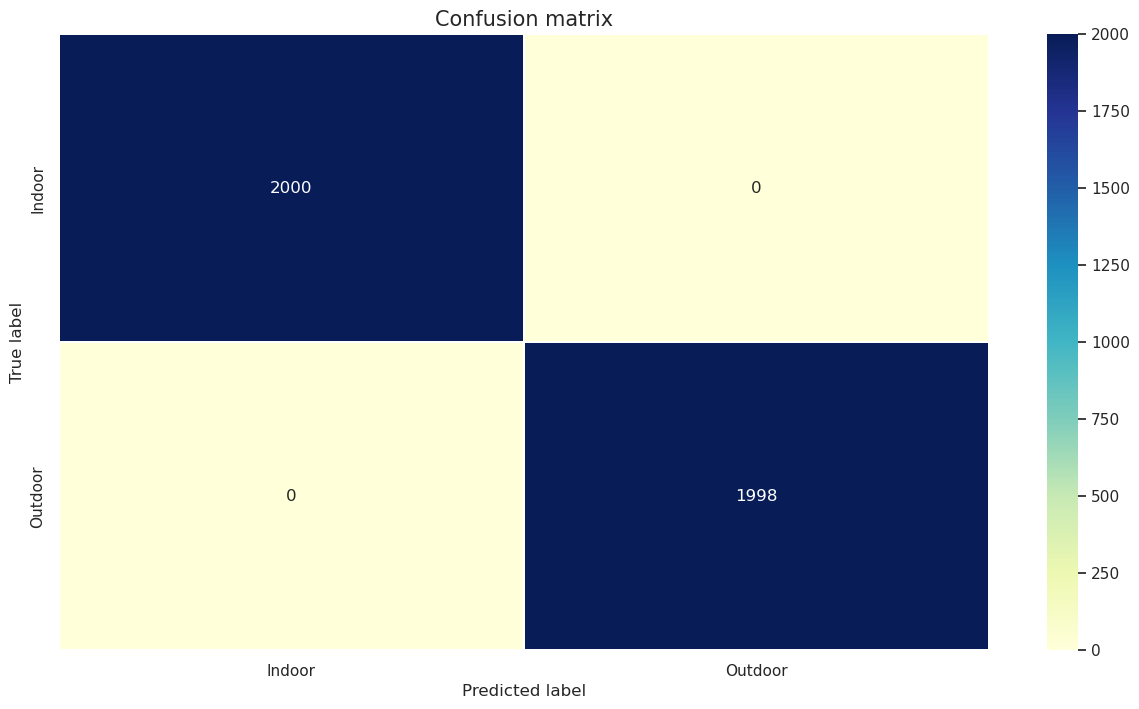

In [46]:
import tensorflow as tf
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Load the TensorFlow Lite model.
interpreter = tf.lite.Interpreter(trained_Model_Lite_Path)
interpreter.allocate_tensors()

# Get the input and output details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()



# Load the test data.
X_test = X 
y_test = y 



# Test the model on the test data.
correct = 0
y_pred = []
for i in range(len(X_test)):
    # Preprocess the input data.
    input_data = X_test[i].astype(np.float32)
    input_data = np.expand_dims(input_data, axis=0)

    # Set the input tensor.
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference.
    interpreter.invoke()

    # Get the output tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    prediction = np.argmax(output_data)

    # Check if the prediction is correct.
    if prediction == (y_test[i]):
        correct += 1
    y_pred.append(prediction)

accuracy = correct / len(X_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))




# Convert y_test from one-hot encoded array to 1D array of labels.
y_test_labels = np.argmax(np.expand_dims(y_test, axis=0), axis=1)


# confusion matrix
LABELS = [
    'Indoor',
    'Outdoor'
]
class_labels = LABELS
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



## Comparison of Trained Model and Lite Version of Trained Model

In [47]:
print("Comparison of Trained Model and Lite Version of Trained Model :")
test_Accuracy_Trained_Model =  (test_acc*100)
test_Accuracy_Trained_Model_Lite = accuracy * 100
print("Trained Model (Full) - Test Accuracy: %.2f%%" % (test_Accuracy_Trained_Model))
print("Trained Model (Lite) - Test Accuracy: {:.2f}%".format(test_Accuracy_Trained_Model_Lite))


Comparison of Trained Model and Lite Version of Trained Model :
Trained Model (Full) - Test Accuracy: 100.00%
Trained Model (Lite) - Test Accuracy: 100.00%
